In [16]:
import os
import time

import numpy as np

# from sklearn.linear_model import LinearRegression
# from sklearn.utils import resample
from scipy.signal import find_peaks

# import plotly.express as px
# import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from collab.utils import find_repo_root

# from collab.foraging import toolkit as ft
from collab.foraging import locust as lc
from collab.foraging import toolkit as ft

# import arviz as az

# import torch.nn.functional as F
# import pyro.distributions as dist
# import pyro.optim as optim
# from pyro.nn import PyroModule
# from pyro.infer.autoguide import (
#     AutoNormal,
#     AutoDiagonalNormal,
#     AutoMultivariateNormal,
#     init_to_mean,
#     init_to_value,
# )
from pyro.contrib.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
# from pyro.optim import Adam
# from pyro.infer import Predictive
# from pyro.infer import MCMC, NUTS


# import jax.numpy as jnp
# from jax import random
import numpyro
import numpyro.distributions as dist
# import numpyro.optim as optim
# from numpyro.diagnostics import print_summary
# from numpyro.infer import Predictive, SVI, Trace_ELBO
# from numpyro.infer.autoguide import AutoLaplaceApproximation


import os

# import logging

# logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
# derivation_logger = logging.getLogger(__name__)

root = find_repo_root()


smoke_test = "CI" in os.environ
smoke_test = True
subset_starts = 420
subset_ends = 430 if smoke_test else 480
desired_frames = 500 if smoke_test else 900

In [2]:
# 1800 seconds overall

locust_data_path = os.path.join(root, "data/foraging/locust/15EQ20191202_tracked.csv")

df = lc.load_and_clean_locust(
    path=locust_data_path,
    desired_frames=desired_frames,
    grid_size=45,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
)

loc_subset = df["subset"]
loc_all = df["all_frames"]

original_frames: 45000
original_shape: (675000, 4)
resulting_frames: 500
resulting_shape: (7500, 4)
min_time 1
max_time 500


In [3]:
# uncomment this if you're interested in processing the whole dataset
# instead of the subsample

# start_time = time.time()
# loc_all = ft.derive_predictors(loc_all, sampling_rate= .1)
# end_time = time.time()
# print("time taken", end_time - start_time)
# takes about 5 minutes to process the whole dataset
# with sampling rate .1

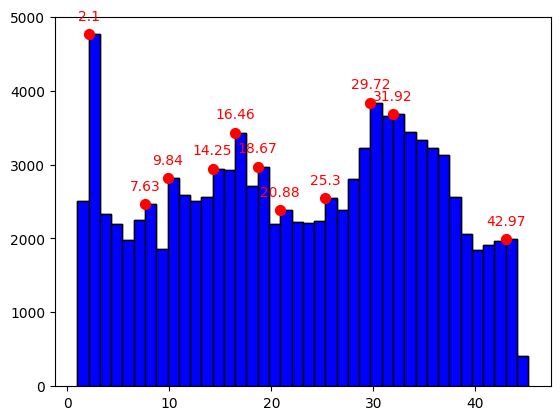

In [4]:
locust_distances = ft.foragers_to_forager_distances(loc_all.foragers)

# if you only care about distances in the subset
# locust_distances = ft.foragers_to_forager_distances(loc_subset.foragers)

distancesDF = pd.concat(locust_distances)
distancesDF.shape

distances_list = distancesDF.values.ravel().tolist()

distances_list = list(filter(lambda x: x != 0, distances_list))

hist, bins, _ = plt.hist(distances_list, bins=40, color="blue", edgecolor="black")
peaks, _ = find_peaks(hist)

plt.hist(distances_list, bins=40, color="blue", edgecolor="black")
plt.scatter(bins[peaks], hist[peaks], c="red", marker="o", s=50, label="Peaks")

peak_values = hist[peaks]
peak_positions = np.round(bins[peaks], 2)

for i, peak_x in enumerate(bins[peaks]):
    plt.annotate(
        f"{peak_positions[i]}",
        (peak_x, hist[peaks][i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=10,
        color="red",
    )

# this suggests there is no proximity minimum other than what's excluded by physical overlap
# and that a decent guess for optimal proximity is around 2.11

Text(0.5, 1.0, 'Proximity score used in predictor derivation')

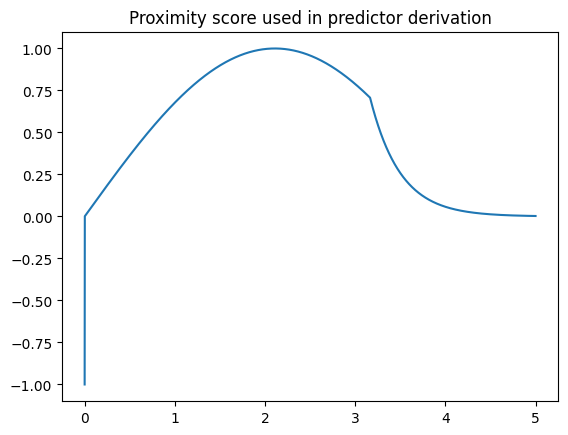

In [5]:
# this illustrates the proximity function that we will use
# in predictor derivation

start = 0.0
end = 5.0
step = 0.001
x = [start + i * step for i in range(int((end - start) / step) + 1)]
y = [
    ft.proximity_score(_d, getting_worse=0.0001, optimal=2.11, proximity_decay=3)
    for _d in x
]
plt.plot(x, y)
plt.title("Proximity score used in predictor derivation")

In [6]:
loc_subset = ft.derive_predictors(
    loc_subset,
    rewards_decay=0.4,
    visibility_range=90,
    getting_worse=0.001,
    optimal=2.11,
    proximity_decay=3,
    generate_communicates_indicator=True,
    info_time_decay=10,
    info_spatial_decay=0.1,
    finders_tolerance=2,
    time_shift=subset_starts - 1,
    sampling_rate=0.1,
    restrict_to_invisible=False,
)

2023-12-13 14:57:14,578 - traces done
2023-12-13 14:57:15,083 - visibility done
2023-12-13 14:57:17,248 - proximity done
2023-12-13 14:57:17,413 - how_far done
2023-12-13 14:57:17,531 - derivedDF done
2023-12-13 14:57:17,531 - starting to generate communicates
2023-12-13 14:57:20,181 - communicates done


In [7]:
ft.animate_foragers(
    loc_subset,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_communicate=1,
    plot_traces=True,
    trace_multiplier=15,
    communicate_multiplier=1,
)

In [8]:
loc_subset_robust = ft.prep_data_for_robust_inference(loc_subset, gridsize=9)

print(loc_subset_robust.columns)

Index(['x', 'y', 'trace', 'time', 'trace_standardized', 'distance',
       'distance_x', 'distance_y', 'visibility', 'forager', 'proximity',
       'proximity_standardized', 'how_far_squared', 'how_far_squared_scaled',
       'communicate', 'communicate_standardized', 'proximity_cat', 'trace_cat',
       'visibility_cat', 'communicate_cat', 'proximity_id', 'trace_id',
       'communicate_id', 'how_far'],
      dtype='object')


In [9]:
data = ft.get_tensorized_data(loc_subset)

proximity, trace, visibility, communicate, how_far = (
    data["proximity_standardized"],
    data["trace_standardized"],
    data["visibility"],
    data["communicate_standardized"],
    data["how_far"],
)

ft.visualise_forager_predictors(trace, proximity, how_far, com=communicate)

Initial dataset size: 26664
Complete cases: 26664


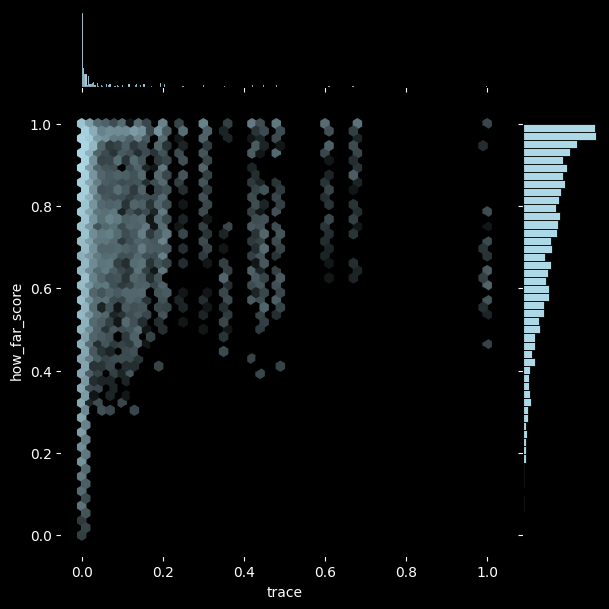

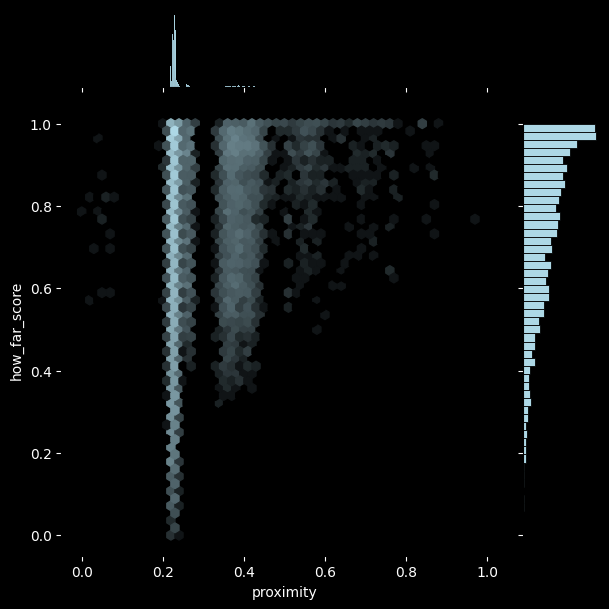

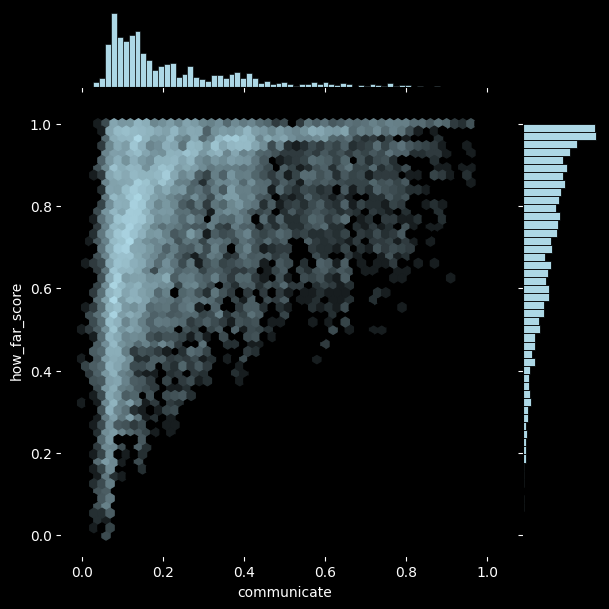

In [10]:
# alternative visualisation
x_to_plot = [trace, proximity, communicate]
x_labels = ["trace", "proximity", "communicate"]
y = how_far

# if seaborn gives deprecation warnings, here's a hacky fix
# import warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)

Colors = ["black", "lightblue"]
cmap = colors.LinearSegmentedColormap.from_list("blackToBlue", Colors)

for idx, x in enumerate(x_to_plot):
    # Create the jointplot
    g = sns.jointplot(
        x=x,
        y=y,
        kind="hex",
        gridsize=50,
        cmap=cmap,
        norm=colors.LogNorm(),
        joint_kws=dict(facecolor="k"),
        marginal_kws=dict(facecolor="lightblue", edgecolor="black"),
    )

    # Set the main plot and marginal histograms background to black
    g.ax_joint.set_facecolor("black")
    g.ax_marg_x.set_facecolor("black")
    g.ax_marg_y.set_facecolor("black")

    # Set the background of the entire figure to black
    g.fig.set_facecolor("black")

    # Set axis labels
    g.set_axis_labels(x_labels[idx], "how_far_score", color="white")

    # Set tick labels to white for visibility against the black background
    g.ax_joint.tick_params(axis="both", colors="white")
    g.ax_marg_x.tick_params(axis="x", colors="white")
    g.ax_marg_y.tick_params(axis="y", colors="white")

    plt.show()

In [11]:
locust = loc_subset.derivedDF

print(locust.columns)
# # gridsize = 9

# locust["proximity_id"] = locust.proximity_cat.astype("category").cat.codes
# locust["trace_id"] = locust.trace_cat.astype("category").cat.codes
# locust["communicate_id"] = locust.communicate_cat.astype("category").cat.codes
# locust["how_far"] = locust.how_far_squared_scaled

Index(['x', 'y', 'trace', 'time', 'trace_standardized', 'distance',
       'distance_x', 'distance_y', 'visibility', 'forager', 'proximity',
       'proximity_standardized', 'how_far_squared', 'how_far_squared_scaled',
       'communicate', 'communicate_standardized', 'proximity_cat', 'trace_cat',
       'visibility_cat', 'communicate_cat', 'proximity_id', 'trace_id',
       'communicate_id', 'how_far'],
      dtype='object')


                          proximity_standardized  trace_standardized  \
proximity_standardized                  1.000000            0.183990   
trace_standardized                      0.183990            1.000000   
communicate_standardized                0.355486            0.387698   

                          communicate_standardized  
proximity_standardized                    0.355486  
trace_standardized                        0.387698  
communicate_standardized                  1.000000  


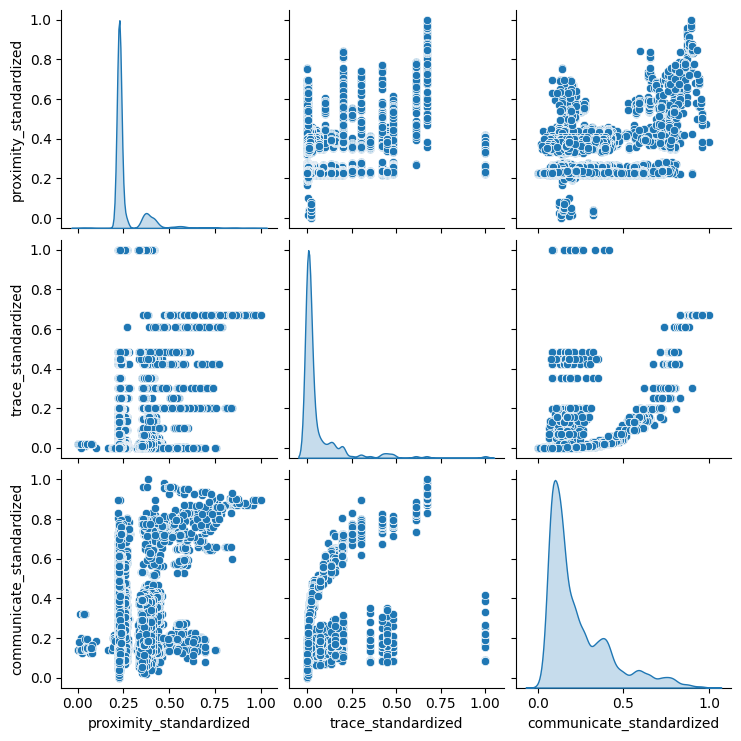

In [12]:
# note predictors do not seem independent which will damage identifiability
# let's not use them in one model

# to some extent, illustrated by the spearman correlation matrix
subset = locust[
    ["proximity_standardized", "trace_standardized", "communicate_standardized"]
]
print(subset.corr(method="spearman"))
# note however, there is a lot of variation in the data, so inspect the pair plot
g = sns.pairplot(subset, diag_kind="kde", height=2.5)

In [18]:
def discretized_p(proximity_id, how_far):
        p = numpyro.sample("p", dist.Normal(0, 0.5).expand([len(set(proximity_id))]))
        sigma = numpyro.sample("sigma", dist.Exponential(1))
        mu = p[proximity_id]
        numpyro.sample("how_far", dist.Normal(mu, sigma), obs=how_far)
        
guide_p = AutoLaplaceApproximation(discretized_p)

svi_p = SVI(
        discretized_p,
        guide_p,
        optim.Adam,
        Trace_ELBO(),
        proximity_id=df.proximity_id.values,
        how_far=df.how_far.values,
    )

NameError: name 'SVI' is not defined

In [13]:
svi_result_p, svi_result_t, svi_result_c = ft.get_svi_results(locust)

TypeError: TracePosterior.__init__() got an unexpected keyword argument 'proximity_id'

In [ ]:
# # cleanup of extreme values resulting from empty cells

# summary = {}
# summary["id_p"] = sorted(locust["proximity_id"].unique())
# summary["params_p"] = svi_result_p.params["auto_loc"][:-1]
# summary["std_p"] = locust.groupby("proximity_id")["how_far"].std()

# summary["id_t"] = sorted(locust["trace_id"].unique())[:-1]
# summary["params_t"] = svi_result_t.params["auto_loc"][:-2]
# summary["std_t"] = locust.groupby("trace_id")["how_far"].std()[:-1]


# summary["id_c"] = sorted(locust["communicate_id"].unique())
# summary["params_c"] = svi_result_c.params["auto_loc"][:-1]
# summary["std_c"] = locust.groupby("communicate_id")["how_far"].std()


# assert (
#     len(summary["id_p"]) == len(summary["params_p"]) == len(summary["std_p"])
# ), "Lengths of id_p, params_p, and std_p do not match."
# assert (
#     len(summary["id_t"]) == len(summary["params_t"]) == len(summary["std_t"])
# ), "Lengths of id_t, params_t, and std_t do not match."
# assert (
#     len(summary["id_c"]) == len(summary["params_c"]) == len(summary["std_c"])
# ), "Lengths of id_c, params_c, and std_c do not match."

In [ ]:
# lr_p, lr_t, lr_c = [LinearRegression() for _ in range(3)]

# X_p = np.array(summary["id_p"]).reshape(-1, 1)
# X_t = np.array(summary["id_t"]).reshape(-1, 1)
# X_c = np.array(summary["id_c"]).reshape(-1, 1)


# lr_p.fit(X_p, summary["params_p"], sample_weight=1 / summary["std_p"])
# lr_t.fit(X_t, summary["params_t"], sample_weight=1 / summary["std_t"])
# lr_c.fit(X_c, summary["params_c"], sample_weight=1 / summary["std_c"])


# X_new = np.arange(0, 8.1, 0.1).reshape((-1, 1))
# p_pred = lr_p.predict(X_new)
# t_pred = lr_t.predict(X_new)
# c_pred = lr_c.predict(X_new)

In [ ]:
# def sample_and_plot_coef(coef, input, model):
#     coef_samples = []
#     for _ in range(1000):
#         X_resampled, y_resampled = resample(
#             input, summary[f"params_{coef}"], random_state=np.random.randint(1000)
#         )

#         model.fit(X_resampled, y_resampled)
#         coef_samples.append(model.coef_[0])

#     histogram_trace = go.Histogram(
#         x=coef_samples,
#         marker=dict(color="blue"),
#     )

#     layout = go.Layout(
#         title=f"Histogram of coef_samples_{coef}",
#         xaxis=dict(title="Coefficient Value"),
#         yaxis=dict(title="Frequency"),
#         paper_bgcolor="black",
#         plot_bgcolor="black",
#         font=dict(color="white"),
#     )

#     fig = go.Figure(data=[histogram_trace], layout=layout)
#     fig.show()


# sample_and_plot_coef("p", X_p, lr_p)
# sample_and_plot_coef("t", X_t, lr_t)
# sample_and_plot_coef("c", X_c, lr_c)

In [ ]:
# def plot_summaries(coef, model, pred, type, ylim=(0, 1.2)):
#     fig = px.scatter(
#         x=summary[f"id_{coef}"],
#         y=summary[f"params_{coef}"],
#         error_y=summary[f"std_{coef}"] / 2,
#         opacity=0.9,
#         template="plotly_dark",
#     )

#     fig.add_scatter(
#         x=X_new.flatten(),
#         y=pred,
#         mode="lines",
#         name="Your Line Name",
#         line=dict(color="red", width=2),
#         showlegend=False,
#     )

#     fig.update_layout(
#         title=f"{type}: estimated means, weighted linear model (w = {np.round(model.coef_, decimals=3)}) and raw data variances",
#         xaxis_title=type,
#         yaxis_title="how far score",
#     )

#     if ylim:
#         fig.update_yaxes(range=ylim)

#     fig.show()


# plot_summaries("p", lr_p, p_pred, "Proximity", ylim=(0, 1))
# plot_summaries("t", lr_t, t_pred, "Trace")
# plot_summaries("c", lr_c, c_pred, "Communicate")